In [1]:
import matplotlib.pyplot as plt
from collections import Counter

import numpy as np
import torch
from sklearn.cluster import KMeans
from torch import nn
from torch import optim
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
from tqdm import tqdm

In [2]:
X = np.concatenate(
    [np.random.rand(300, 3), np.random.rand(300, 3) + 2, np.random.rand(300, 3) - 5, np.random.rand(300, 3) + 20])

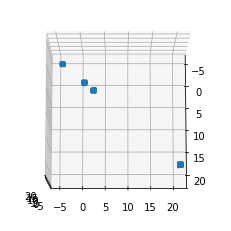

In [3]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
# ax.scatter(x, y, z, s=1)
ax.scatter(*X.T, s=1)
ax.view_init(elev=80., azim=0)
plt.show()

In [4]:
class AE(nn.Module):
    def __init__(self):
        super(AE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(3, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 3),
        )
        self.decoder = nn.Sequential(
            nn.Linear(3, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 3),
        )

    def encode(self, x):
        return self.encoder(x)

    def decode(self, x):
        return self.decoder(x)

    def forward(self, x):
        return self.decoder(self.encoder(x))

model = AE()
X_torch = torch.from_numpy(X).float()
ds = TensorDataset(X_torch, )
dl = DataLoader(ds, 256, True)

loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [5]:
pbar = tqdm(range(300))
for _ in pbar:
    for batch, in dl:
        batch = batch.float()
        output = model(batch)
        loss = loss_fn(batch, output)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        pbar.set_postfix({'loss': loss.item()})


100%|██████████| 300/300 [00:13<00:00, 21.43it/s, loss=0.0413]


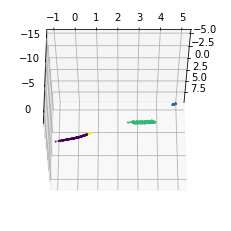

In [6]:
model.eval()
with torch.no_grad():
    encode = model.encoder(X_torch).detach().cpu().numpy()

km = KMeans(4)
km.fit(encode)
cluster_centers = km.cluster_centers_

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(*encode.T, s=1, c=km.predict(encode)
           )
# ax.scatter(*cluster_centers.T, c='red', s=100)
ax.view_init(elev=150, azim=00)
plt.show()

In [7]:
class LastModel(nn.Module):
    def __init__(self, encoder, cluster_centers):
        super(LastModel, self).__init__()
        self.encoder = encoder
        self.cluster_centers = nn.Parameter(torch.from_numpy(cluster_centers).float())

    def forward(self, x):
        # batch x
        encoding = self.encoder(x)

        distances1 = torch.cdist(encoding, self.cluster_centers, p=2.)
        distances2 = (distances1 ** 2) + 1
        distances3 = 1 / distances2
        q_ij = distances3 / distances3.sum(1)[:, None]
        f_j = q_ij.sum(0)
        p_ij = (q_ij ** 2) / f_j[None, :]
        p_ij = p_ij / p_ij.sum(1)[:, None]

        return p_ij, q_ij, f_j

last_model = LastModel(model.encoder, cluster_centers)
optimizer = optim.Adam(last_model.parameters(), lr=0.005)
loss_fn = nn.KLDivLoss(reduction='batchmean')

  0%|          | 0/1000 [00:00<?, ?it/s, loss1=0.0706]

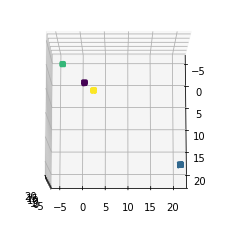

 10%|▉         | 99/1000 [00:00<00:08, 111.32it/s, loss1=0.022] 

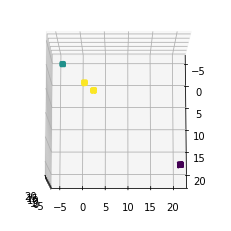

 19%|█▉        | 191/1000 [00:02<00:07, 104.11it/s, loss1=0.0181]

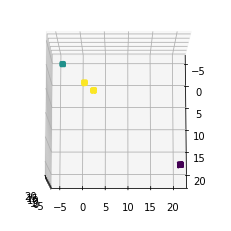

 29%|██▉       | 291/1000 [00:03<00:06, 105.34it/s, loss1=0.014] 

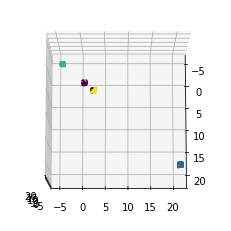

 39%|███▉      | 390/1000 [00:04<00:05, 102.72it/s, loss1=0.0122]

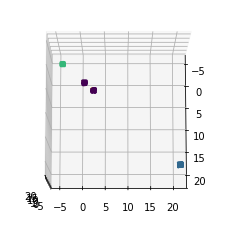

 50%|█████     | 500/1000 [00:05<00:04, 101.95it/s, loss1=0.0111]

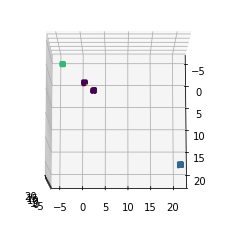

 60%|█████▉    | 599/1000 [00:06<00:03, 103.97it/s, loss1=0.0107]

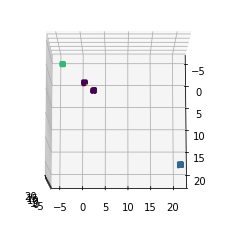

 70%|██████▉   | 696/1000 [00:07<00:03, 82.88it/s, loss1=0.00942] 

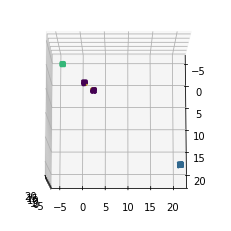

 79%|███████▉  | 793/1000 [00:08<00:02, 102.89it/s, loss1=0.0088] 

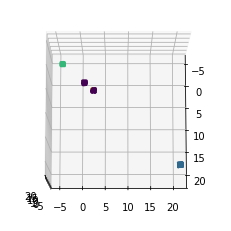

 89%|████████▉ | 894/1000 [00:09<00:00, 106.81it/s, loss1=0.00851]

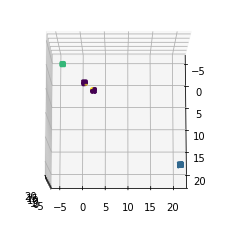

100%|██████████| 1000/1000 [00:10<00:00, 96.87it/s, loss1=0.00778]


In [8]:
pbar = tqdm(range(1000))
for epoch in pbar:
    model.train()
    last_model.train()

    p_ij, q_ij, f_j = last_model(X_torch)
    loss1 = loss_fn(q_ij.log(), p_ij)

    optimizer.zero_grad()
    loss1.backward()
    optimizer.step()
    pbar.set_postfix({'loss1': loss1.item()})

    if epoch % 100 == 0:
        fig = plt.figure()
        ax = fig.add_subplot(projection='3d')
        ax.scatter(*X.T, s=1, c=q_ij.argmax(1).numpy())
        ax.view_init(elev=80., azim=0)
        plt.show()

In [9]:
Counter(q_ij.argmax(1).numpy())

Counter({0: 497, 3: 103, 2: 300, 1: 300})